In [1]:
%pip install gpytorch;

Note: you may need to restart the kernel to use updated packages.


In [2]:
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Make a toy dataset

In [4]:
# Define size of the datacube
size_z = 10
size_y = 10
size_x = 10

In [6]:
def gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise):
    z = np.exp(-((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return z + np.random.normal(size=z.shape) * noise

def make_test_dataset(size_z, size_y, size_x, x0, y0, sigma_x, sigma_y, noise):
    x = np.linspace(-3, 3, size_x)
    y = np.linspace(-3, 3, size_y)

    x, y = np.meshgrid(x, y)

    z = np.zeros((size_z,size_y,size_x))

    # Factor to vary maxima of Gaussian
    z_range = np.linspace(-5, 5, size_z)
    
    for i in range(size_z):
        z[i] = gaussian_2d(x, y, x0, y0, sigma_x, sigma_y, noise) * np.exp(-(z_range[i] ** 2) / 2)

    return x, y, z

# Generate the dimensions and vectors, z will be our 'DEMs'
x, y, z = make_test_dataset(size_z, size_y, size_x, 0, 0, 1, 1, 0.05)

# We define a function that creates tuples where the tuples are always sorted, random, and never further apart than a set step
import random

def random_indices_sorted(size_max, step):
    # Initialize an empty list to store the tuples
    tuples = []
    
    # Generate the first tuple with random values
    first_value = random.randint(0, size_max-step)  # The maximum value is 95 to ensure at least a 5-unit difference.
    second_value = random.randint(first_value + 1, min(first_value + step, size_max))  # Ensure the second value is within 5 units of the first one.
    
    tuples.append((first_value, second_value))
    
    # Generate the remaining tuples
    for _ in range(99):
        first_value = random.randint(0, size_max-step)  # The maximum value is 95 to ensure at least a 5-unit difference.
        second_value = random.randint(first_value + 1, min(first_value + step, size_max))  # Ensure the second value is within 5 units of the first one.
    
        tuples.append((first_value, second_value))
    return tuples

# Generate the indices
z_out = random_indices_sorted(size_z, 2)
y_out = random_indices_sorted(size_y, 3)
x_out = random_indices_sorted(size_x, 3)

z_original = z.copy()

# Poke the dataset
for i in range(len(z_out)):
    z[z_out[i][0]:z_out[i][1],y_out[i][0]:y_out[i][1],x_out[i][0]:x_out[i][1]] = np.nan



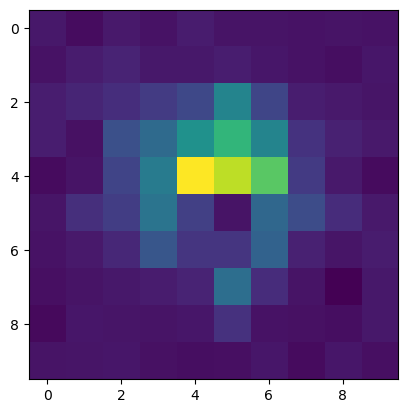

In [7]:
# Plot the average tile in space
plt.imshow(np.nanmean(z, axis = 0))

/tmp/ipykernel_2255/2308854857.py:1: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.nanmean(z, axis = 2), axis = 1))


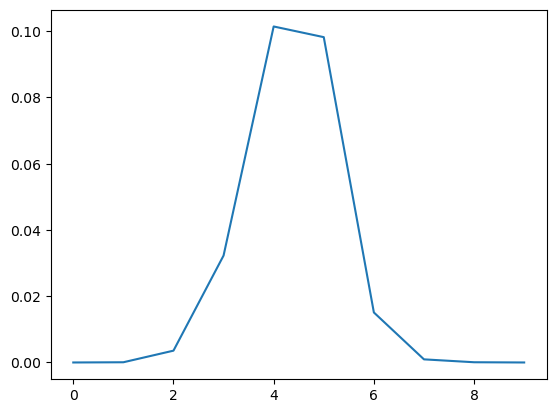

In [8]:
# Plot the average slice in time
plt.plot(np.nanmean(np.nanmean(z, axis = 2), axis = 1))

# Calculate the regression in Time

In [9]:
import torch
import time
import gpytorch
from tqdm import tqdm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Gpytorch versions
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class ExactGPModelGrid(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelGrid, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.MaternKernel(), grid_size=grid_size, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# In the following function, time_tensor is the complete time-axis of our dataset.
# mask_tensor is used to mask the NaNs (hence masked time_tensor and total_tensor will be smaller than their original size)
# total_tensor represents the DEM values at 1 point i,j in space with NaNs in its time-series.

def run_gp_interpolation(total_step_tensor, mask_tensor, total_data_tensor, use_structure=False, use_gpu=False, n_iter=10):

    # Base tensor is gonna be time masked
    base_tensor = total_step_tensor[mask_tensor]

    # Training tensor
    training_tensor = total_data_tensor[mask_tensor]

    # Initialize the model based on the masked tensors
    ModelClass = ExactGPModelGrid if use_structure else ExactGPModel
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ModelClass(base_tensor, training_tensor, likelihood)

    if use_gpu:
        base_tensor = base_tensor.cuda()
        training_tensor = training_tensor.cuda()
        model = model.cuda()    
        likelihood = likelihood.cuda()
    else:
        base_tensor = base_tensor.cpu()
        training_tensor = training_tensor.cpu()
        model = model.cpu()
        likelihood = likelihood.cpu()

    # Transition to train mode
    model.train()
    likelihood.train()

    # Set up optimizter and log-likelihood
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    t0 = time.time()
    for _ in range(n_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(base_tensor)
        # Calc loss and backprop gradients
        loss = -mll(output, training_tensor)
        loss.backward()
    tf = time.time()
    elapsed = tf - t0


    # Prediction on the total time_tensor.
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(total_step_tensor))



    return observed_pred



In [12]:
# Convert inputs to torch
z_tensor  = torch.from_numpy(z.astype(np.float32))
y_tensor = torch.from_numpy(y.astype(np.float32))
x_tensor = torch.from_numpy(x.astype(np.float32))
time_tensor = torch.from_numpy(np.linspace(0,size_z,z.shape[0]).astype(np.float32))

# Time function will loop over each entry of x and y

# Initialize z_preds_time where we plug-in the interpolation in time
z_preds_time = [[None for j in range(x_tensor.shape[0])] for i in range(y_tensor.shape[0])]

# Initialize z_preds_space where we plug-in the interpolation in space
z_preds_space = [[None] for t in range(time_tensor.shape[0])]

# Temporal interpolation
pbar = tqdm(total=(x_tensor.shape[0]*y_tensor.shape[0]))
for i in range(len(y_tensor)):
    for j in range(len(x_tensor)):
        mask_nans = torch.logical_not(torch.isnan(z_tensor[:,i,j]))
        z_preds_time[i][j] = run_gp_interpolation(time_tensor, mask_nans, z_tensor[:,i,j])
        pbar.update(1)


# Spatial interpolation

# Gather x and y in the same tensor
xy_arr    = np.stack([x.flatten(), y.flatten()], axis=-1).astype(np.float32)
xy_tensor = torch.from_numpy(xy_arr)

pbar2 = tqdm(total=(time_tensor.shape[0]))
for t in range(len(time_tensor)):
    input_tensor = z_tensor[t].flatten()
    mask_nans = torch.logical_not(torch.isnan(input_tensor))
    z_preds_space[t] = run_gp_interpolation(xy_tensor, mask_nans, input_tensor)
    pbar2.update(1)

 80%|████████  | 8/10 [00:00<00:00, 38.02it/s]

### Rearrange the outputs in 3D arrays

In [13]:
pred_time = z.copy()
pred_space = z.copy()

# First in time
for i in range(y_tensor.shape[0]):
    for j in range(x_tensor.shape[0]):
        pred_time[:,i,j] = z_preds_time[i][j].mean.numpy()

# Then in space
for t in range(time_tensor.shape[0]):
    pred_space[t] = z_preds_space[t].mean.numpy().reshape(pred_space.shape[1], pred_space.shape[2])

100%|██████████| 10/10 [00:17<00:00, 38.02it/s]

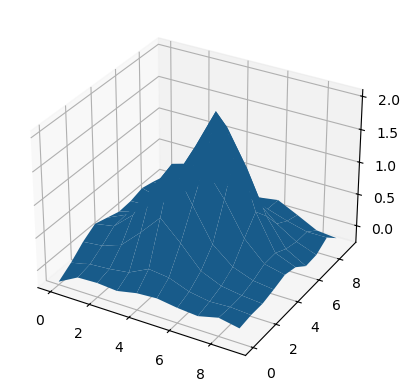

In [24]:

import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up grid and test data
hf = plt.figure()
ha = hf.add_subplot(111, projection='3d')

x = np.arange(0, size_x)
y = np.arange(0, size_y)

X, Y = numpy.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ha.plot_surface(X, Y, pred_space[0])


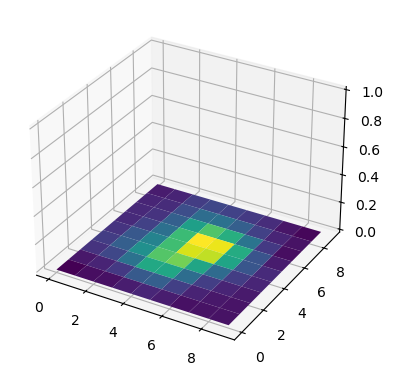

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

# create the figure
fig = plt.figure(figsize=(10,10))

# show the 3D rotated projection
ax2 = fig.add_subplot(121, projection='3d')
cset = ax2.plot_surface(X, Y, pred_space[0], cmap='viridis')
cset2 = ax2.plot_surface(X, Y, pred_space[1], cmap='viridis')
ax2.set_zlim((0.,1.))

plt.show()

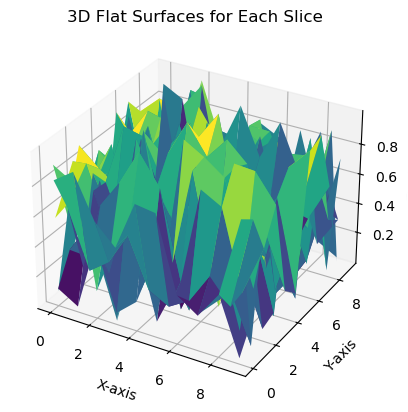

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a sample 3D array (replace this with your actual data)
# For this example, we'll create a 3D array with random data.
depth, rows, cols = 5, 10, 10
array = np.random.rand(depth, rows, cols)

# Create a figure and a 3D subplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each slice in the 0th dimension as separate flat surfaces
for i in range(depth):
    X, Y = np.meshgrid(range(rows), range(cols))
    Z = array[i, :, :]
    ax.plot_surface(X, Y, Z, cmap='viridis')  # Adjust the colormap as needed

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Flat Surfaces for Each Slice')

# Show the plot
plt.show()


In [45]:
import numpy as np

image = np.random.randint(100, size=(100, 100, 3))

r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]

result = np.dstack((r, g, b))

print("image shape", image.shape)
print("result shape", result.shape)

image shape (100, 100, 3)
result shape (100, 100, 3)


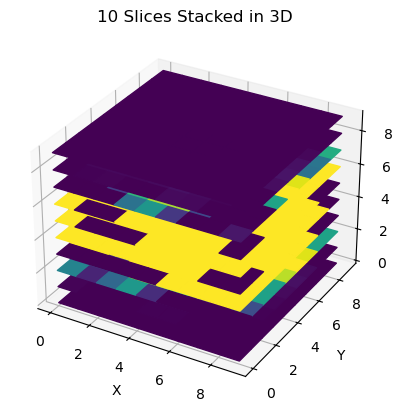

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample 10x100x100 array for demonstration
# Replace this with your actual data
data = pred_space

# Create a figure and an axis for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Number of slices to plot (in this case, 10)
num_slices = data.shape[0]

# Create a colormap for the slices
cmap = plt.get_cmap('viridis')

# Loop through the slices and plot them in 3D
for i in range(num_slices):
    slice_data = data[i, :, :]*1000
    x, y = np.meshgrid(np.arange(slice_data.shape[1]), np.arange(slice_data.shape[0]))
    ax.plot_surface(x, y, i * np.ones_like(slice_data), facecolors=cmap(slice_data), shade=False)

# Customize the plot as needed
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Slice Index')
ax.set_title('Dataset sliced')

# Show the plot
plt.show()
